In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
df = pd.read_csv("ECLearnix.csv")  # replace with your actual file path or DataFrame
df.head()


,User_ID,User_Type,Department,Region,Platform_Source,App_Installed,First_Login_Completed,Days_Since_Last_Activity,Registered_for_Event,Event_Type,Event_Mode,Newsletter_Subscribed,Saved_Event_Count,Feedback_Rating,Course_Completed,Time_Spent_Total_Minutes
0,ECL100000,Faculty,Polytechnic,South,Email,0,1,18,0,STTP,Offline,0,2,5,1,330
1,ECL100001,Faculty,Law,West,LinkedIn,1,0,85,0,Hackathon,Online,0,6,1,0,490
2,ECL100002,Faculty,Medical,North,ACE Website,1,0,6,1,FDP,Hybrid,0,2,3,1,491
3,ECL100003,Professional,Arts,South,Email,0,1,41,0,Conference,Online,1,0,2,0,495
4,ECL100004,Faculty,Science,East,Email,1,0,5,0,Webinar,Online,0,0,4,0,71


In [ ]:
df.isnull().sum()


,0
User_ID,0
User_Type,0
Department,0
Region,0
Platform_Source,0
App_Installed,0
First_Login_Completed,0
Days_Since_Last_Activity,0
Registered_for_Event,0
Event_Type,0


no missing values

In [ ]:
# Step 1: Create a flag for drop-off based on 30-day threshold
df['Is_Dropped'] = df['Days_Since_Last_Activity'] > 30

# Step 2: Calculate drop-off rate per user type
dropoff_rate = df.groupby('User_Type')['Is_Dropped'].mean()

# Step 3: Rank the user types (higher drop-off = higher rank)
user_type_rank = dropoff_rate.rank(method='dense', ascending=False).astype(int) - 1

# Step 4: Map back to the main DataFrame
df['User_Type_Encoded'] = df['User_Type'].map(user_type_rank)

# Step 5: (Optional) View the mapping
print(dropoff_rate)
print(user_type_rank)

User_Type
Entrepreneur    0.658422
Faculty         0.656020
Professional    0.659677
Student         0.657843
Name: Is_Dropped, dtype: float64
User_Type
Entrepreneur    1
Faculty         3
Professional    0
Student         2
Name: Is_Dropped, dtype: int64


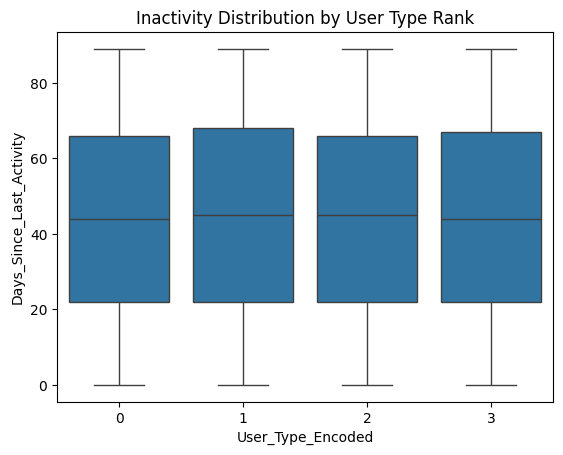

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.boxplot(x='User_Type_Encoded', y='Days_Since_Last_Activity', data=df)
plt.title("Inactivity Distribution by User Type Rank")
plt.show()


In [ ]:
features = ['App_Installed','First_Login_Completed','Registered_for_Event', 'Course_Completed','Newsletter_Subscribed', 'Time_Spent_Total_Minutes']
target = 'User_Type_Encoded'

X = df[features]
y = df[target]


In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)


In [ ]:
from lightgbm import LGBMClassifier

model = LGBMClassifier(
    objective='multiclass',
    num_class=len(y.unique()),
    class_weight='balanced',
    learning_rate=0.05,
    max_depth=7,
    n_estimators=200,
    random_state=42
)

model.fit(X_train, y_train)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000527 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 259
[LightGBM] [Info] Number of data points in the train set: 8000, number of used features: 6
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

LGBMClassifier(class_weight='balanced', learning_rate=0.05, max_depth=7,
               n_estimators=200, num_class=4, objective='multiclass',
               random_state=42)

In [ ]:
from sklearn.metrics import accuracy_score, classification_report

y_pred = model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Accuracy: 0.2325

Classification Report:
               precision    recall  f1-score   support

           0       0.26      0.22      0.24       496
           1       0.24      0.27      0.25       510
           2       0.22      0.20      0.21       506
           3       0.22      0.24      0.23       488

    accuracy                           0.23      2000
   macro avg       0.23      0.23      0.23      2000
weighted avg       0.23      0.23      0.23      2000



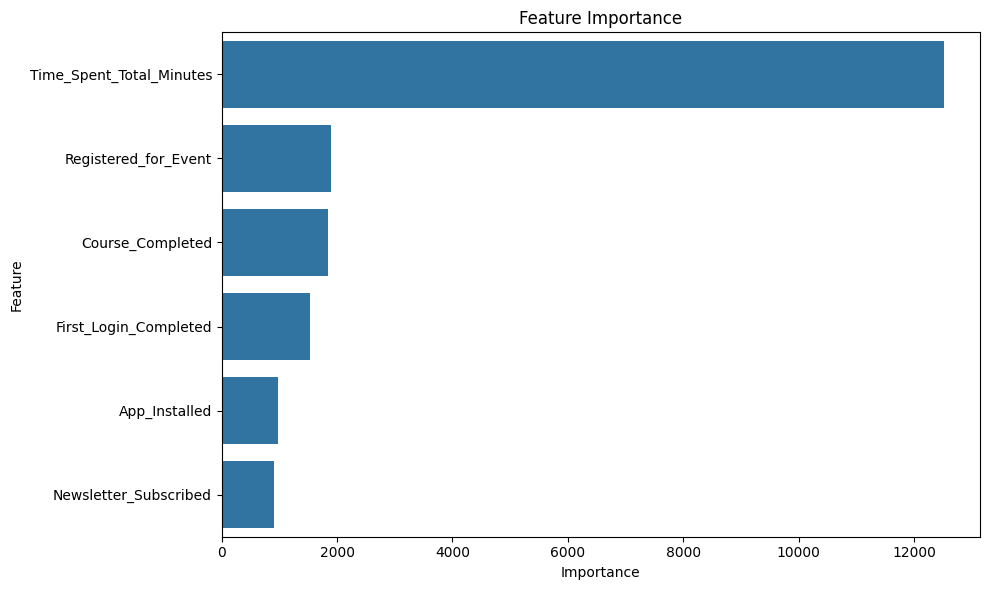

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

feature_importances = model.feature_importances_
features_sorted = sorted(zip(X.columns, feature_importances), key=lambda x: x[1], reverse=True)

plt.figure(figsize=(10, 6))
sns.barplot(x=[f[1] for f in features_sorted], y=[f[0] for f in features_sorted])
plt.title("Feature Importance")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


feature importance of the field time spent is given higher as its the only non-binary valued field in the model and hence holding top responsibility for prediction

In [ ]:
from sklearn.preprocessing import LabelEncoder

le_region = LabelEncoder()
df['Region_Encoded'] = le_region.fit_transform(df['Region'])

# Optional: check the mapping
region_mapping = dict(zip(le_region.classes_, le_region.transform(le_region.classes_)))
print("Region Mapping:", region_mapping)


Region Mapping: {'Central': np.int64(0), 'East': np.int64(1), 'North': np.int64(2), 'South': np.int64(3), 'West': np.int64(4)}


In [ ]:
features = ['App_Installed', 'First_Login_Completed', 'Registered_for_Event',
            'Course_Completed', 'Newsletter_Subscribed', 'Time_Spent_Total_Minutes']

target = 'Region_Encoded'

X = df[features]
y = df[target]


In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)


In [ ]:
from lightgbm import LGBMClassifier

model = LGBMClassifier(
    objective='multiclass',
    num_class=len(y.unique()),
    class_weight='balanced',
    learning_rate=0.05,
    max_depth=7,
    n_estimators=200,
    random_state=42
)

model.fit(X_train, y_train)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000382 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 258
[LightGBM] [Info] Number of data points in the train set: 8000, number of used features: 6
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Ligh

LGBMClassifier(class_weight='balanced', learning_rate=0.05, max_depth=7,
               n_estimators=200, num_class=5, objective='multiclass',
               random_state=42)

In [ ]:
from sklearn.metrics import accuracy_score, classification_report

y_pred = model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Accuracy: 0.2115

Classification Report:
               precision    recall  f1-score   support

           0       0.22      0.23      0.22       394
           1       0.22      0.23      0.22       410
           2       0.19      0.18      0.18       399
           3       0.24      0.22      0.23       415
           4       0.19      0.21      0.20       382

    accuracy                           0.21      2000
   macro avg       0.21      0.21      0.21      2000
weighted avg       0.21      0.21      0.21      2000



In [ ]:
decoded_preds = le_region.inverse_transform(y_pred)


In [ ]:
from sklearn.preprocessing import LabelEncoder

le_dept = LabelEncoder()
df['Department_Encoded'] = le_dept.fit_transform(df['Department'])

# Optional: Check mapping
dept_mapping = dict(zip(le_dept.classes_, le_dept.transform(le_dept.classes_)))
print("Department Mapping:", dept_mapping)


Department Mapping: {'Arts': np.int64(0), 'Commerce': np.int64(1), 'Engineering': np.int64(2), 'Law': np.int64(3), 'Medical': np.int64(4), 'Polytechnic': np.int64(5), 'Science': np.int64(6)}


In [ ]:
features = ['App_Installed', 'First_Login_Completed', 'Registered_for_Event',
            'Course_Completed', 'Newsletter_Subscribed', 'Time_Spent_Total_Minutes']

target = 'Department_Encoded'

X = df[features]
y = df[target]


In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42
)


In [ ]:
from lightgbm import LGBMClassifier

model = LGBMClassifier(
    objective='multiclass',
    num_class=len(y.unique()),
    class_weight='balanced',
    learning_rate=0.05,
    max_depth=7,
    n_estimators=200,
    random_state=42
)

model.fit(X_train, y_train)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001010 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 258
[LightGBM] [Info] Number of data points in the train set: 8000, number of used features: 6
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further spli

LGBMClassifier(class_weight='balanced', learning_rate=0.05, max_depth=7,
               n_estimators=200, num_class=7, objective='multiclass',
               random_state=42)

In [ ]:
from sklearn.metrics import accuracy_score, classification_report

y_pred = model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Accuracy: 0.143

Classification Report:
               precision    recall  f1-score   support

           0       0.12      0.13      0.13       288
           1       0.12      0.12      0.12       275
           2       0.18      0.16      0.17       283
           3       0.17      0.15      0.16       300
           4       0.14      0.12      0.13       280
           5       0.13      0.14      0.13       284
           6       0.16      0.17      0.16       290

    accuracy                           0.14      2000
   macro avg       0.14      0.14      0.14      2000
weighted avg       0.14      0.14      0.14      2000



In [ ]:
decoded_preds = le_dept.inverse_transform(y_pred)


In [ ]:
from sklearn.preprocessing import LabelEncoder

le_platform = LabelEncoder()
df['Platform_Source_Encoded'] = le_platform.fit_transform(df['Platform_Source'])

# Optional: Check mapping
platform_mapping = dict(zip(le_platform.classes_, le_platform.transform(le_platform.classes_)))
print("Platform Source Mapping:", platform_mapping)


Platform Source Mapping: {'ACE Website': np.int64(0), 'Email': np.int64(1), 'Instagram': np.int64(2), 'LinkedIn': np.int64(3), 'WhatsApp': np.int64(4), 'YouTube': np.int64(5)}


In [ ]:
features = ['App_Installed', 'First_Login_Completed', 'Registered_for_Event',
            'Course_Completed', 'Newsletter_Subscribed', 'Time_Spent_Total_Minutes']

target = 'Platform_Source_Encoded'

X = df[features]
y = df[target]


In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42
)


In [ ]:
from lightgbm import LGBMClassifier

model = LGBMClassifier(
    objective='multiclass',
    num_class=len(y.unique()),
    class_weight='balanced',
    learning_rate=0.05,
    max_depth=7,
    n_estimators=200,
    random_state=42
)

model.fit(X_train, y_train)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001036 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 256
[LightGBM] [Info] Number of data points in the train set: 8000, number of used features: 6
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [War

LGBMClassifier(class_weight='balanced', learning_rate=0.05, max_depth=7,
               n_estimators=200, num_class=6, objective='multiclass',
               random_state=42)

In [ ]:
from sklearn.metrics import accuracy_score, classification_report

y_pred = model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Accuracy: 0.1505

Classification Report:
               precision    recall  f1-score   support

           0       0.15      0.14      0.14       326
           1       0.14      0.15      0.14       333
           2       0.16      0.19      0.17       324
           3       0.17      0.18      0.17       335
           4       0.13      0.13      0.13       334
           5       0.17      0.12      0.14       348

    accuracy                           0.15      2000
   macro avg       0.15      0.15      0.15      2000
weighted avg       0.15      0.15      0.15      2000



In [ ]:
decoded_preds = le_platform.inverse_transform(y_pred)


In [ ]:
from sklearn.preprocessing import LabelEncoder

label_cols = ['Region', 'Department', 'Platform_Source', 'User_Type']
for col in label_cols:
    df[col + '_Encoded'] = LabelEncoder().fit_transform(df[col])


In [ ]:
features = ['Region_Encoded', 'Department_Encoded', 'Platform_Source_Encoded', 'User_Type_Encoded']
target = 'Is_Dropped'
X = df[features]
y = df[target]


In [ ]:
from lightgbm import LGBMClassifier

model = LGBMClassifier(random_state=42)
model.fit(X, y)


[LightGBM] [Info] Number of positive: 6580, number of negative: 3420
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000164 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 22
[LightGBM] [Info] Number of data points in the train set: 10000, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.658000 -> initscore=0.654394
[LightGBM] [Info] Start training from score 0.654394


LGBMClassifier(random_state=42)

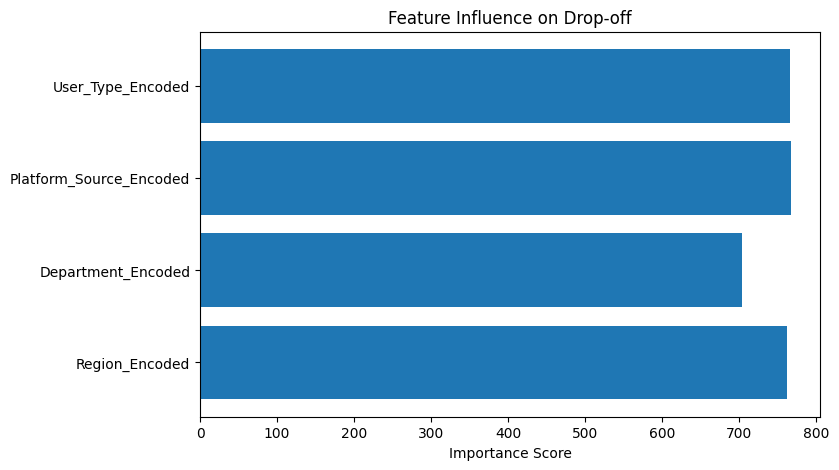

Region_Encoded: 763
Department_Encoded: 704
Platform_Source_Encoded: 767
User_Type_Encoded: 766


In [ ]:
import matplotlib.pyplot as plt

importances = model.feature_importances_
feature_names = X.columns

plt.figure(figsize=(8, 5))
plt.barh(feature_names, importances)
plt.xlabel("Importance Score")
plt.title("Feature Influence on Drop-off")
plt.show()

# Optional: print importance values
for name, score in zip(feature_names, importances):
    print(f"{name}: {score}")


Platform Source Drives Drop-Off the Most
Users coming from certain platforms (like a web event, ad campaign, or referral) may be less sticky than others.

LightGBM's built-in feature importance (like the 767, 766 scores you saw earlier) is typically based on:

Number of times a feature is used to split

Or information gain at those splits.

🔵LightGBM sees frequency and gain.

/usr/local/lib/python3.11/dist-packages/shap/explainers/_tree.py:583: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


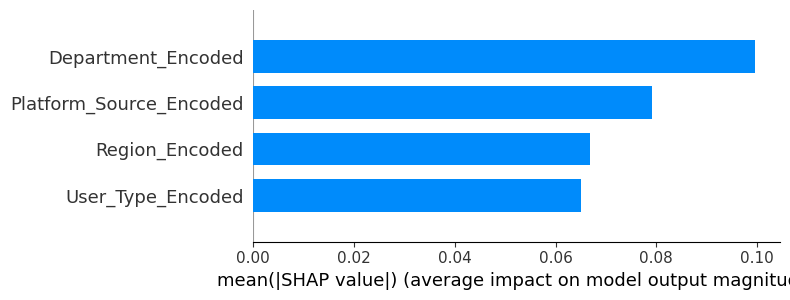

In [ ]:
import shap

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)

shap.summary_plot(shap_values, X, plot_type="bar")


For interpretability and real-world action → SHAP is more reliable.

So based on your SHAP chart:

Department should be prioritized in segmentation.

Platform is still very relevant, just not the most consistent contributor across all users.

🟢 SHAP sees per-user contribution — even rare but powerful influences matter.